# Overview of Past Simulations for Eindhoven Example

This notebook provides an overview of past simulations for the Eindhoven example. The past simulations are stored at `p:\archivedprojects\11209195-012-urban-forecasting`. The following steps are performed to analyze the simulations:

1. **Reading the Rainfall Event**: Extract rainfall events from the `.bui` files.
2. **Checking Simulation Status**: Verify if the simulation is complete by analyzing the `.dia` files.
3. **Reading Runoff Data**: Extract the runoff generated from the rainfall event by reading the `*his_output.nc` files.
4. **Reading Flood Data**: Extract the total flood volume in the system from the `*map_output.nc` files.
5. **Visualizing Results**: Create visuals to understand:
    - How many events were run.
    - How many simulations were successful and how many were not.
    - The types of rainfall events available.
    - The types of flooding events available.

This analysis is crucial for understanding the dataset structure, which will be used to train the GNN model. By visualizing the data, we can better comprehend its structure and characteristics.

## Additional Dependencies

To run this notebook, ensure the following dependencies are installed:

- **Jupyter Notebook**: Install using `pip install notebook`.
- **Seaborn**: Install using `pip install seaborn`.

These dependencies are required for creating visualizations and running the notebook interactively.


In [30]:
from pathlib import Path
import glob
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define the path to the simulations
simulation_path = Path(r'p:\archivedprojects\11209195-012-urban-forecasting')
bui_path = simulation_path.joinpath(r'Data\bui_files')
dia_path = simulation_path.joinpath(r'Models\Delft3DFM\Output')
his_path = simulation_path.joinpath(r'Models\Delft3DFM\Output')
map_path = simulation_path.joinpath(r'Models\Delft3DFM\Output')

print('Simulation path:', simulation_path)
print('BUI path:', bui_path)
print('DIA path:', dia_path)
print('HIS path:', his_path)
print('MAP path:', map_path)


Simulation path: p:\archivedprojects\11209195-012-urban-forecasting
BUI path: p:\archivedprojects\11209195-012-urban-forecasting\Data\bui_files
DIA path: p:\archivedprojects\11209195-012-urban-forecasting\Models\Delft3DFM\Output
HIS path: p:\archivedprojects\11209195-012-urban-forecasting\Models\Delft3DFM\Output
MAP path: p:\archivedprojects\11209195-012-urban-forecasting\Models\Delft3DFM\Output


## Step 1: Extract Rainfall Events and Verify Completion

In this step, we perform the following tasks:

1. **Extract Rainfall Events**: Identify all rainfall events by reading the `.bui` files from the specified directory.
2. **Verify Simulation Completion**: Check the corresponding `.dia` files to determine if the simulations for each rainfall event have been successfully completed.

The extracted rainfall events and their completion status will be stored in a dictionary for further analysis.

In [31]:
def read_rainfall_events(path):
    bui_files = list(path.glob('*.bui'))  # Use Path.glob to find all .bui files
    rainfall_events = []
    for file in bui_files:     
        rainfall_events.append(file.stem) 

    return rainfall_events


def check_dia_files(event_names, dia_path): 
    # Initialize a dictionary to store the results
    results = {}
    
    for event_name in event_names:
        # Construct the file path
        dia_file = dia_path / f"{event_name}.bui_dia.dia" 
        
        # Check if the file exists
        if not dia_file.exists():
            results[event_name] = False
            continue
        
        # Read the file
        with open(dia_file, 'r') as file:
            lines = file.readlines()
        
        # Search for the keyword indicating computation finished
        for line in lines:
            if "Computation finished at:" in line:
                results[event_name] = True
                break
        else:
            results[event_name] = False
    
    return results



In [32]:
# get rainfall_events and dia_results.
rainfall_events = read_rainfall_events(bui_path)
print(f"Found {len(rainfall_events)} rainfall events in .bui files.")
dia_results = check_dia_files(rainfall_events, dia_path)
finished_count = sum(1 for finished in dia_results.values() if finished)
print(f"Number of finished events: {finished_count} out of {len(rainfall_events)}")

Found 114 rainfall events in .bui files.
Number of finished events: 104 out of 114


## Step 2: Read Rainfall, Runoff and Flood Volume Timeseries

In this step, we process the input and output data and extract the following timeseries data:

1. **Rainfall Timeseries**: The rainfall data is read from the corresponding `.bui` file for each event.
2. **Runoff Timeseries**: The runoff data is extracted from the `*his_output.nc` file for each event.
3. **Total Flood Volume Timeseries**: The total flood volume data is extracted from the `*map_output.nc` files and sum at all nodes for each event.

They are processed in one function altogether. The results are stored as a dataframe for each event.

In [33]:
def read_bui_file(event_name, bui_path):
    # Construct the file path
    bui_file = bui_path / f"{event_name}.bui"
    
    # Check if the file exists
    if not bui_file.exists():
        raise FileNotFoundError(f"The file {bui_file} does not exist.")
    
    # Read the file
    with open(bui_file, 'r') as file:
        lines = file.readlines()
    
    # Find the data block
    data_start_index = None
    for i, line in enumerate(lines):
        if "* The last part is the data for each time step." in line:
            data_start_index = i + 1
            break
    
    if data_start_index is None:
        raise ValueError("Data block not found in the file.")
    
    # Parse metadata
    metadata_line = lines[data_start_index].strip()
    metadata_parts = metadata_line.split()
    start_date = datetime.strptime(" ".join(metadata_parts[:6]), "%Y %m %d %H %M %S")

    # Parse timeseries data
    timeseries = []
    for line in lines[data_start_index + 1:]:
        value = line.strip()
        if value:
            timeseries.append(float(value))
    
    # Create a time-indexed series
    timestamps = [start_date + timedelta(seconds=300 * i) for i in range(len(timeseries))]
    timeseries_data = pd.Series(timeseries, index=timestamps, name="Rainfall (mm)")
    
    return {
        "rainfall": timeseries_data
    }

def read_his_file(event_name, his_path):
    # Construct the file path
    his_file = his_path / f"{event_name}.bui_his_output.nc"
    
    # Check if the file exists
    if not his_file.exists():
        raise FileNotFoundError(f"The file {his_file} does not exist.")
    
    # Open the NetCDF file using xarray
    ds = xr.open_dataset(his_file)
    
    # Check if the required variables exist in the dataset
    required_vars = ['water_balance_laterals_in']
    for var in required_vars:
        if var not in ds.variables:
            raise KeyError(f"The variable '{var}' is not found in the file {his_file}.")
    
    # Extract the variables as time series with units
    timeseries_data = {}
    for var in required_vars:
        data = ds[var]
        timeseries_data[var] = pd.Series(
            data.values,
            index=pd.to_datetime(data['time'].values),
            name=f"{data.attrs.get('long_name', var)} ({data.attrs.get('units', 'unknown')})"
        )
    
    # Close the dataset
    ds.close()
    return timeseries_data

def read_map_file(event_name, map_path):
    # Construct the file path
    map_file = map_path / f"{event_name}.bui_map_output.nc"
    
    # Check if the file exists
    if not map_file.exists():
        raise FileNotFoundError(f"The file {map_file} does not exist.")
    
    # Open the NetCDF file using xarray
    ds = xr.open_dataset(map_file)
    
    # Check if the required variable exists in the dataset
    if 'mesh1d_volume_on_ground' not in ds.variables:
        raise KeyError(f"The variable 'mesh1d_volume_on_ground' is not found in the file {map_file}.")
    
    # Extract the flood volume timeseries
    flood_volume = ds['mesh1d_volume_on_ground'].sum(dim='mesh1d_nNodes', skipna=True)
    flood_volume_timeseries = pd.Series(
        flood_volume.values,
        index=pd.to_datetime(ds['time'].values),
        name="Flood Volume (m3)"
    )

    # Close the dataset
    ds.close()
    
    return {
        "flood_volume_timeseries": flood_volume_timeseries,
    }

def process_event_data(event_name, bui_path, his_path, map_path):
    """
    Process data for a given event by reading rainfall, HIS, and MAP data.

    Parameters:
        event_name (str): Name of the event.
        bui_path (Path): Path to the .bui files.
        his_path (Path): Path to the .his files.
        map_path (Path): Path to the .map files.

    Returns:
        pd.DataFrame: Combined data for the event.
    """
    # Read the rainfall data
    event_rainfall_data = read_bui_file(event_name, bui_path)
    
    # Read the HIS data
    event_his_data = read_his_file(event_name, his_path)
    
    # Read the MAP data
    event_flood_data = read_map_file(event_name, map_path)
    
    # Combine the data into a single DataFrame
    combined_data = pd.DataFrame({
        "Rainfall (mm)": event_rainfall_data["rainfall"],
        "Runoff (m3/s)": event_his_data['water_balance_laterals_in'],
        "Flood Volume (m3)": event_flood_data["flood_volume_timeseries"]
    })
    
    return combined_data


## Step 3: Compute Event Summary

In this step, we compute summary statistics for each rainfall event. The following metrics are calculated:

1. **Duration (hours)**: The total duration of the event in hours.
2. **Total Rainfall (mm)**: The cumulative rainfall over the entire event.
3. **Max Hourly Rainfall (mm)**: The maximum rainfall recorded in any one-hour period.
4. **Cumulative Laterals In (m³)**: The total volume of water entering the system laterally during the event.
5. **Total Flood Volume (m³)**: The total flood volume accumulated during the event.

These metrics provide a comprehensive overview of each event's characteristics and are stored in a summary table for further analysis and visualization.

In [34]:

def compute_event_summary(event_data_df, event_name):
    # Compute the duration of the event
    duration = (event_data_df.index[-1] - event_data_df.index[0]).total_seconds() / 3600  # in hours

    # Compute the total rainfall amount
    total_rainfall = event_data_df['Rainfall (mm)'].sum()

    # Compute the hourly maximum rainfall rate
    hourly_rainfall = event_data_df['Rainfall (mm)'].resample('h').sum()
    max_hourly_rainfall = hourly_rainfall.max()

    # Compute the cumulative laterals in
    cumulative_laterals_in = event_data_df["Runoff (m3/s)"].sum()*3600

    #     # Compute summary statistics
    total_flood_volume = event_data_df['Flood Volume (m3)'].sum()

    # Create a summary dictionary
    summary = {
        'Event Name': event_name,
        'Duration (hours)': duration,
        'Total Rainfall (mm)': total_rainfall,
        'Max Hourly Rainfall (mm)': max_hourly_rainfall,
        'Cumulative Laterals In (m3)': cumulative_laterals_in,
        'Total Flood Volume (m3)': total_flood_volume,
    }

    return summary


## Step 4: Summarize for All Events

In this step, we aggregate the computed summaries for all rainfall events into a single table. This table provides a comprehensive overview of the key metrics for each event.
This summary table is essential for comparing the characteristics of different events and identifying patterns or trends in the data. The results are stored in a DataFrame and can be exported for further analysis or visualization.

In [35]:
# Initialize a list to store the summary for all events
summary_list = []

# Loop through all events
for event_name in rainfall_events:
    if dia_results[event_name] == False:
        print(f"Event {event_name} is not finished. Skipping...")
        continue
    try:
        event_data_df = process_event_data(event_name, bui_path, his_path, map_path)
        # Compute event summary
        event_summary = compute_event_summary(event_data_df, event_name)
        summary_list.append(event_summary)
 
    except Exception as e:
        print(f"Error processing event {event_name}: {e}")

# Convert the summary list to a DataFrame for better visualization
summary_df = pd.DataFrame(summary_list)

# Print the summary table
print(summary_df)

Event Hydrogram historische bui Cabauw is not finished. Skipping...
Event Hydrogram historische bui De Bilt is not finished. Skipping...
Event Hydrogram historische bui Deelen is not finished. Skipping...
Event Hydrogram historische bui Herwijnen is not finished. Skipping...
Event Hydrogram historische bui Maastricht is not finished. Skipping...
Event Hydrogram historische bui Marknesse is not finished. Skipping...
Event Hydrogram Stresstestbui 04 is not finished. Skipping...
Event Hydrogram Stresstestbui 05 is not finished. Skipping...
Event Hydrogram Stresstestbui 06 is not finished. Skipping...
Event Hydrogram Stresstestbui 07 is not finished. Skipping...
                     Event Name  Duration (hours)  Total Rainfall (mm)  \
0          Hydrogram C_0,5_2014             13.00            25.000000   
1        Hydrogram C_0,5_2030_H             13.00            26.600000   
2        Hydrogram C_0,5_2030_L             13.00            25.700000   
3        Hydrogram C_0,5_2050_H      

In [37]:
# save the summary to a CSV file
summary_csv_path = Path('..\data\Eindhoven\Simulations\event_summary.csv')
summary_df.to_csv(summary_csv_path, index=False)



## Visualize and Analyze the Simulations

To better understand the data, we first analyse summary table and create visualizations. These visuals will help us analyze the key metrics, such as total rainfall, maximum hourly rainfall, cumulative laterals in, and total flood volume across different events.


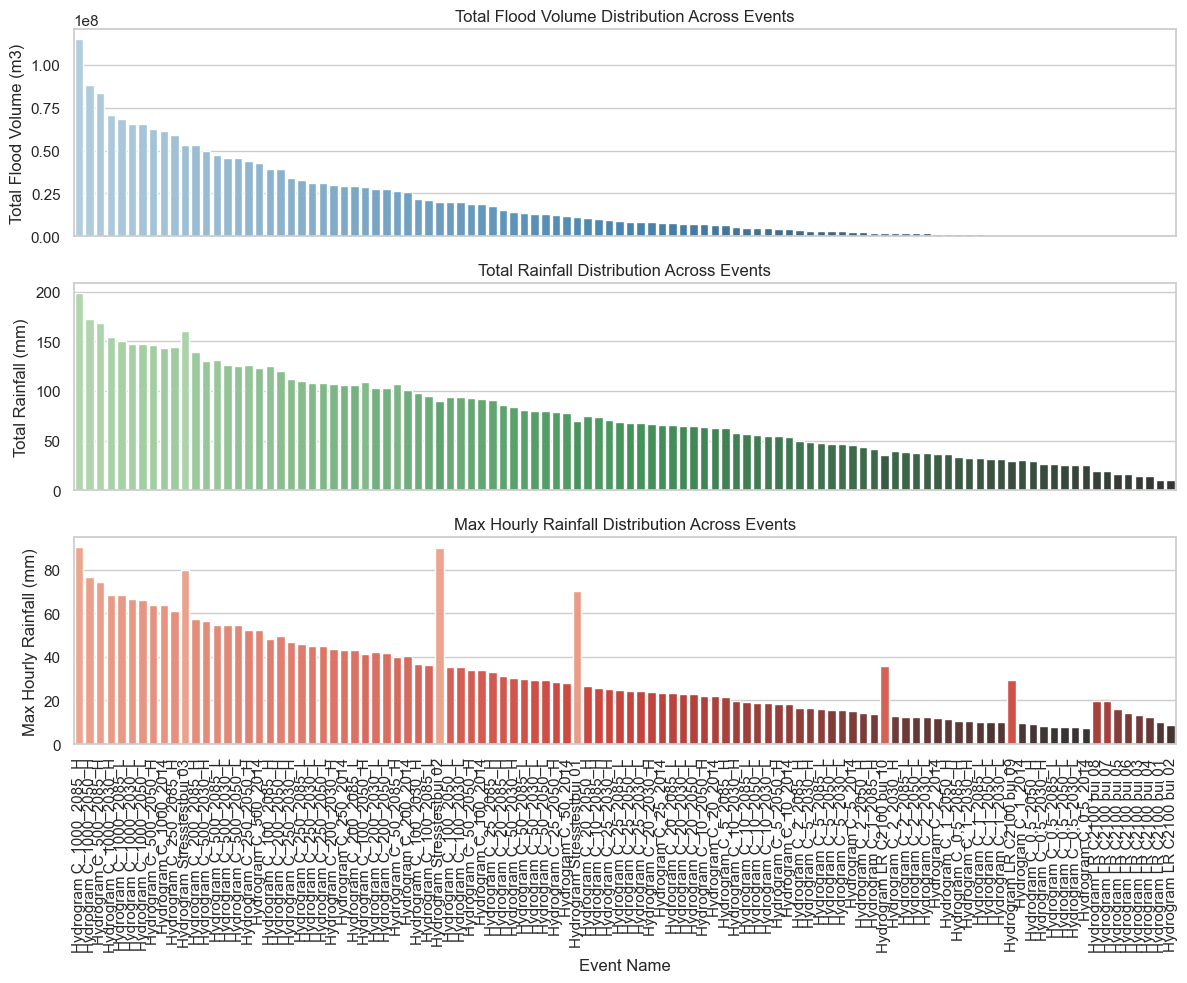

In [11]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot Total Flood Volume distribution
sns.barplot(
    x="Event Name",
    y="Total Flood Volume (m3)",
    data=summary_df.sort_values("Total Flood Volume (m3)", ascending=False),
    ax=axes[0],
    palette="Blues_d",
    hue="Event Name",
    legend=False
)
axes[0].set_title("Total Flood Volume Distribution Across Events")
axes[0].set_ylabel("Total Flood Volume (m3)")
axes[0].tick_params(axis='x', rotation=90)

# Plot Total Rainfall distribution
sns.barplot(
    x="Event Name",
    y="Total Rainfall (mm)",
    data=summary_df.sort_values("Total Rainfall (mm)", ascending=False),
    ax=axes[1],
    palette="Greens_d",
    hue="Event Name",
    legend=False
)
axes[1].set_title("Total Rainfall Distribution Across Events")
axes[1].set_ylabel("Total Rainfall (mm)")
axes[1].tick_params(axis='x', rotation=90)

# plot  Max Hourly Rainfall (mm) distribution
sns.barplot(
    x="Event Name",
    y="Max Hourly Rainfall (mm)",
    data=summary_df.sort_values("Max Hourly Rainfall (mm)", ascending=False),
    ax=axes[2],
    palette="Reds_d",
    hue="Event Name",
    legend=False
)
axes[2].set_title("Max Hourly Rainfall Distribution Across Events") 
axes[2].set_ylabel("Max Hourly Rainfall (mm)")
axes[2].tick_params(axis='x', rotation=90)



# Adjust layout
plt.tight_layout()
plt.show()

In this step, we create individual visualizations for each event. This allows us to analyze the rainfall, runoff, and flood volume timeseries for each event in detail. By visualizing the data event by event, we can better understand the temporal dynamics and relationships between these variables.

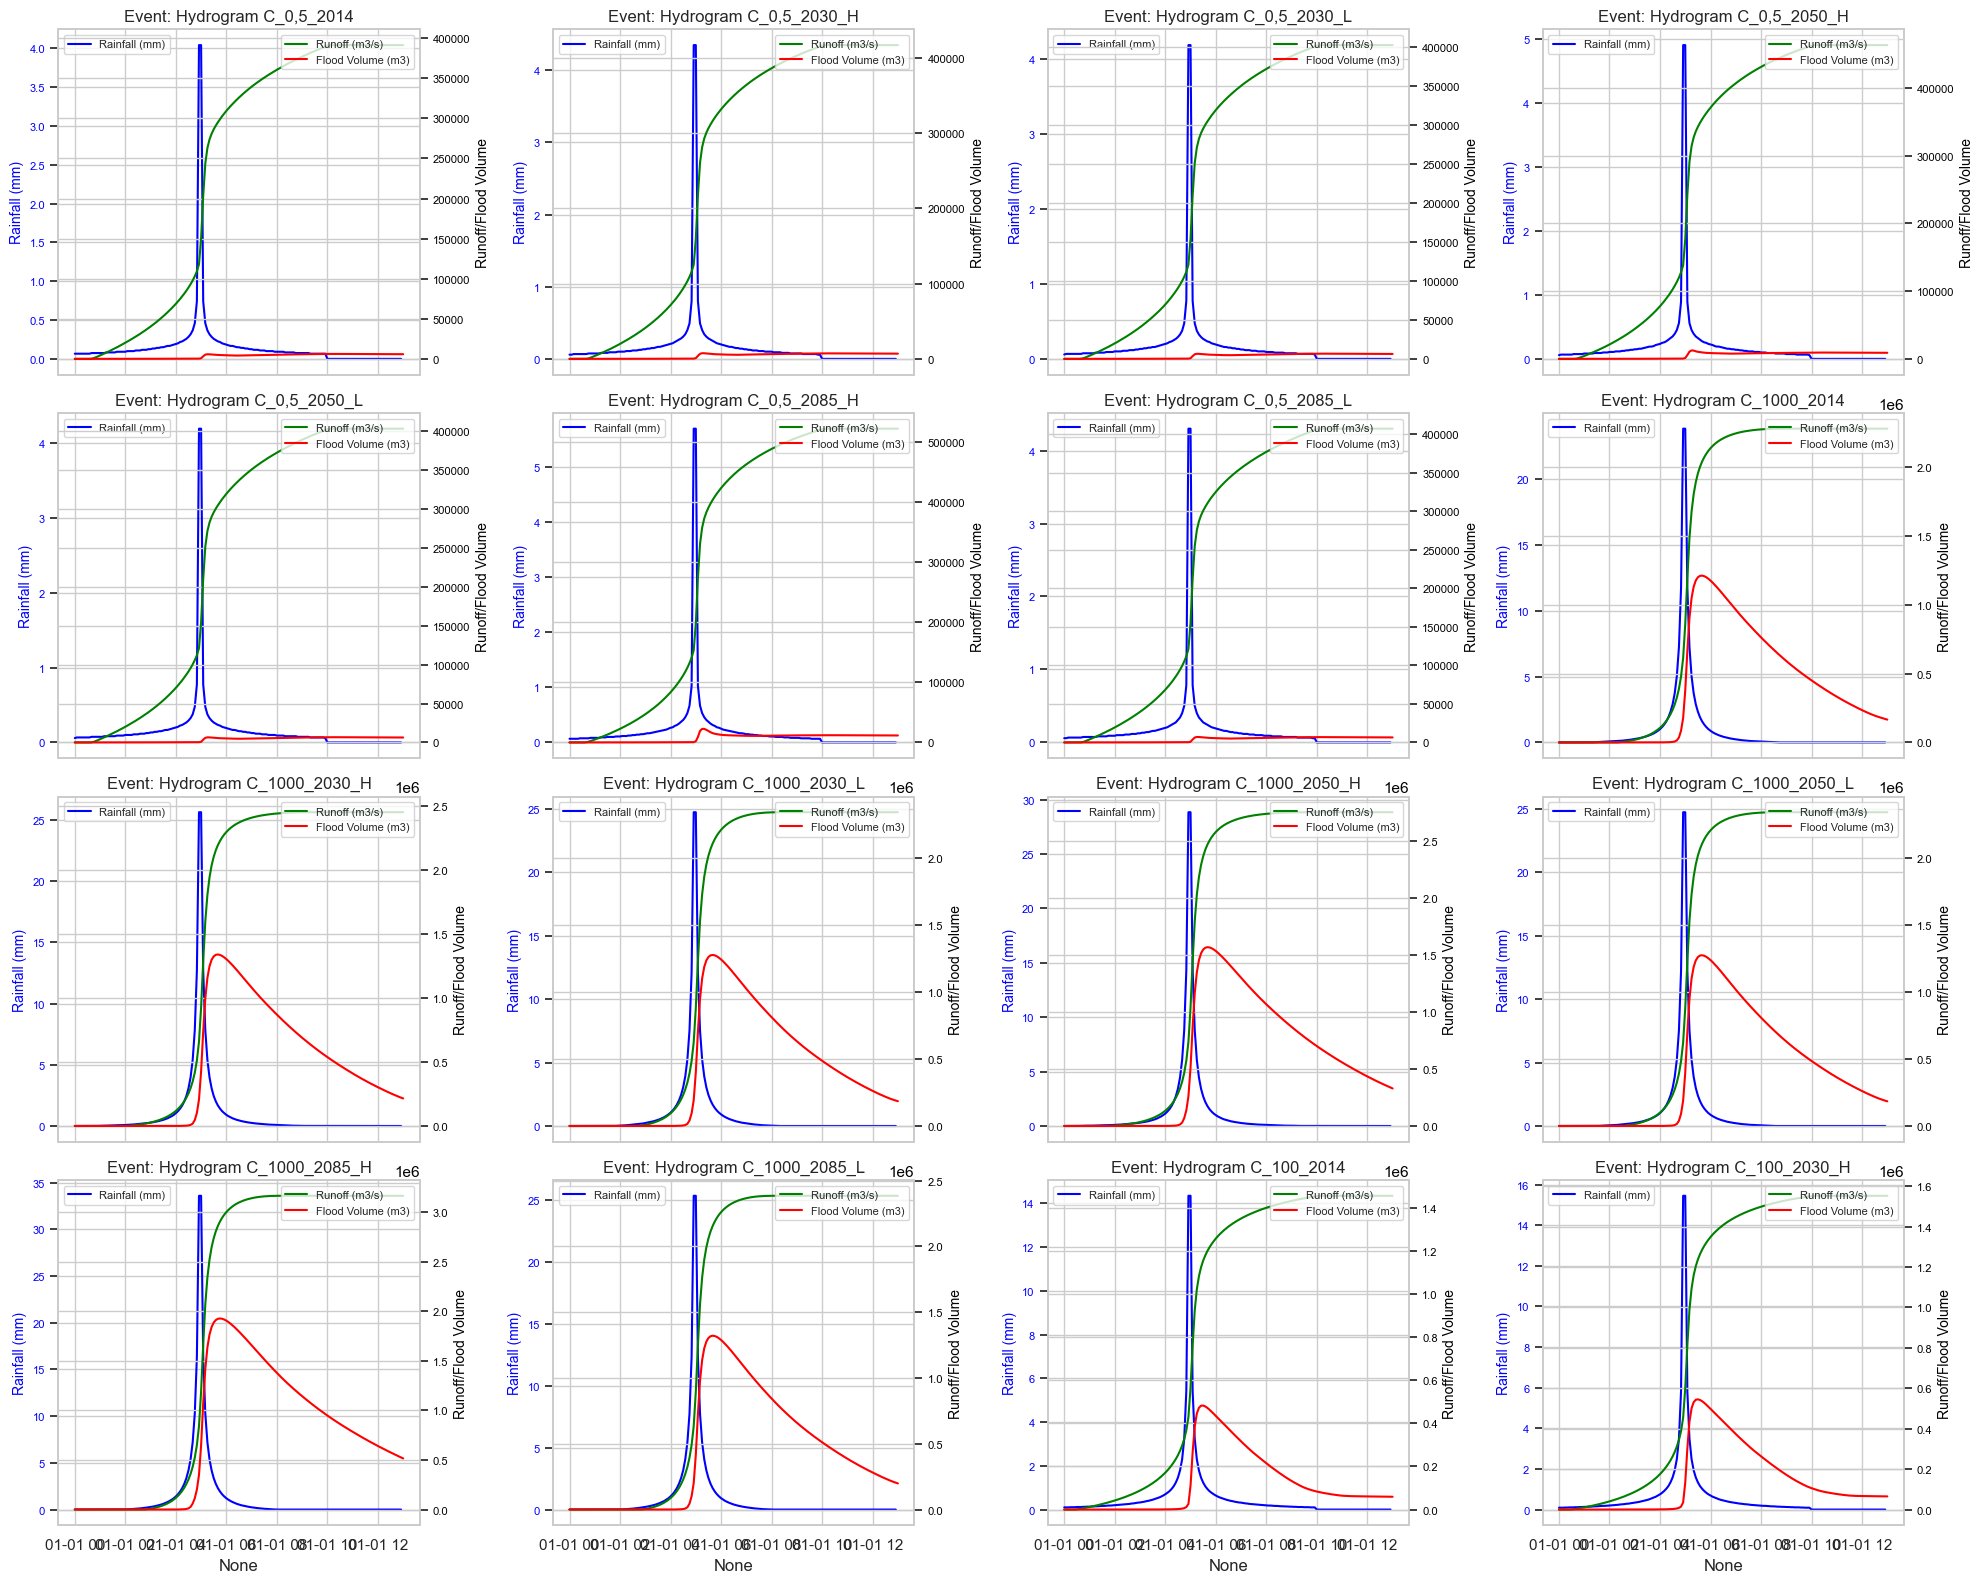

<Figure size 640x480 with 0 Axes>

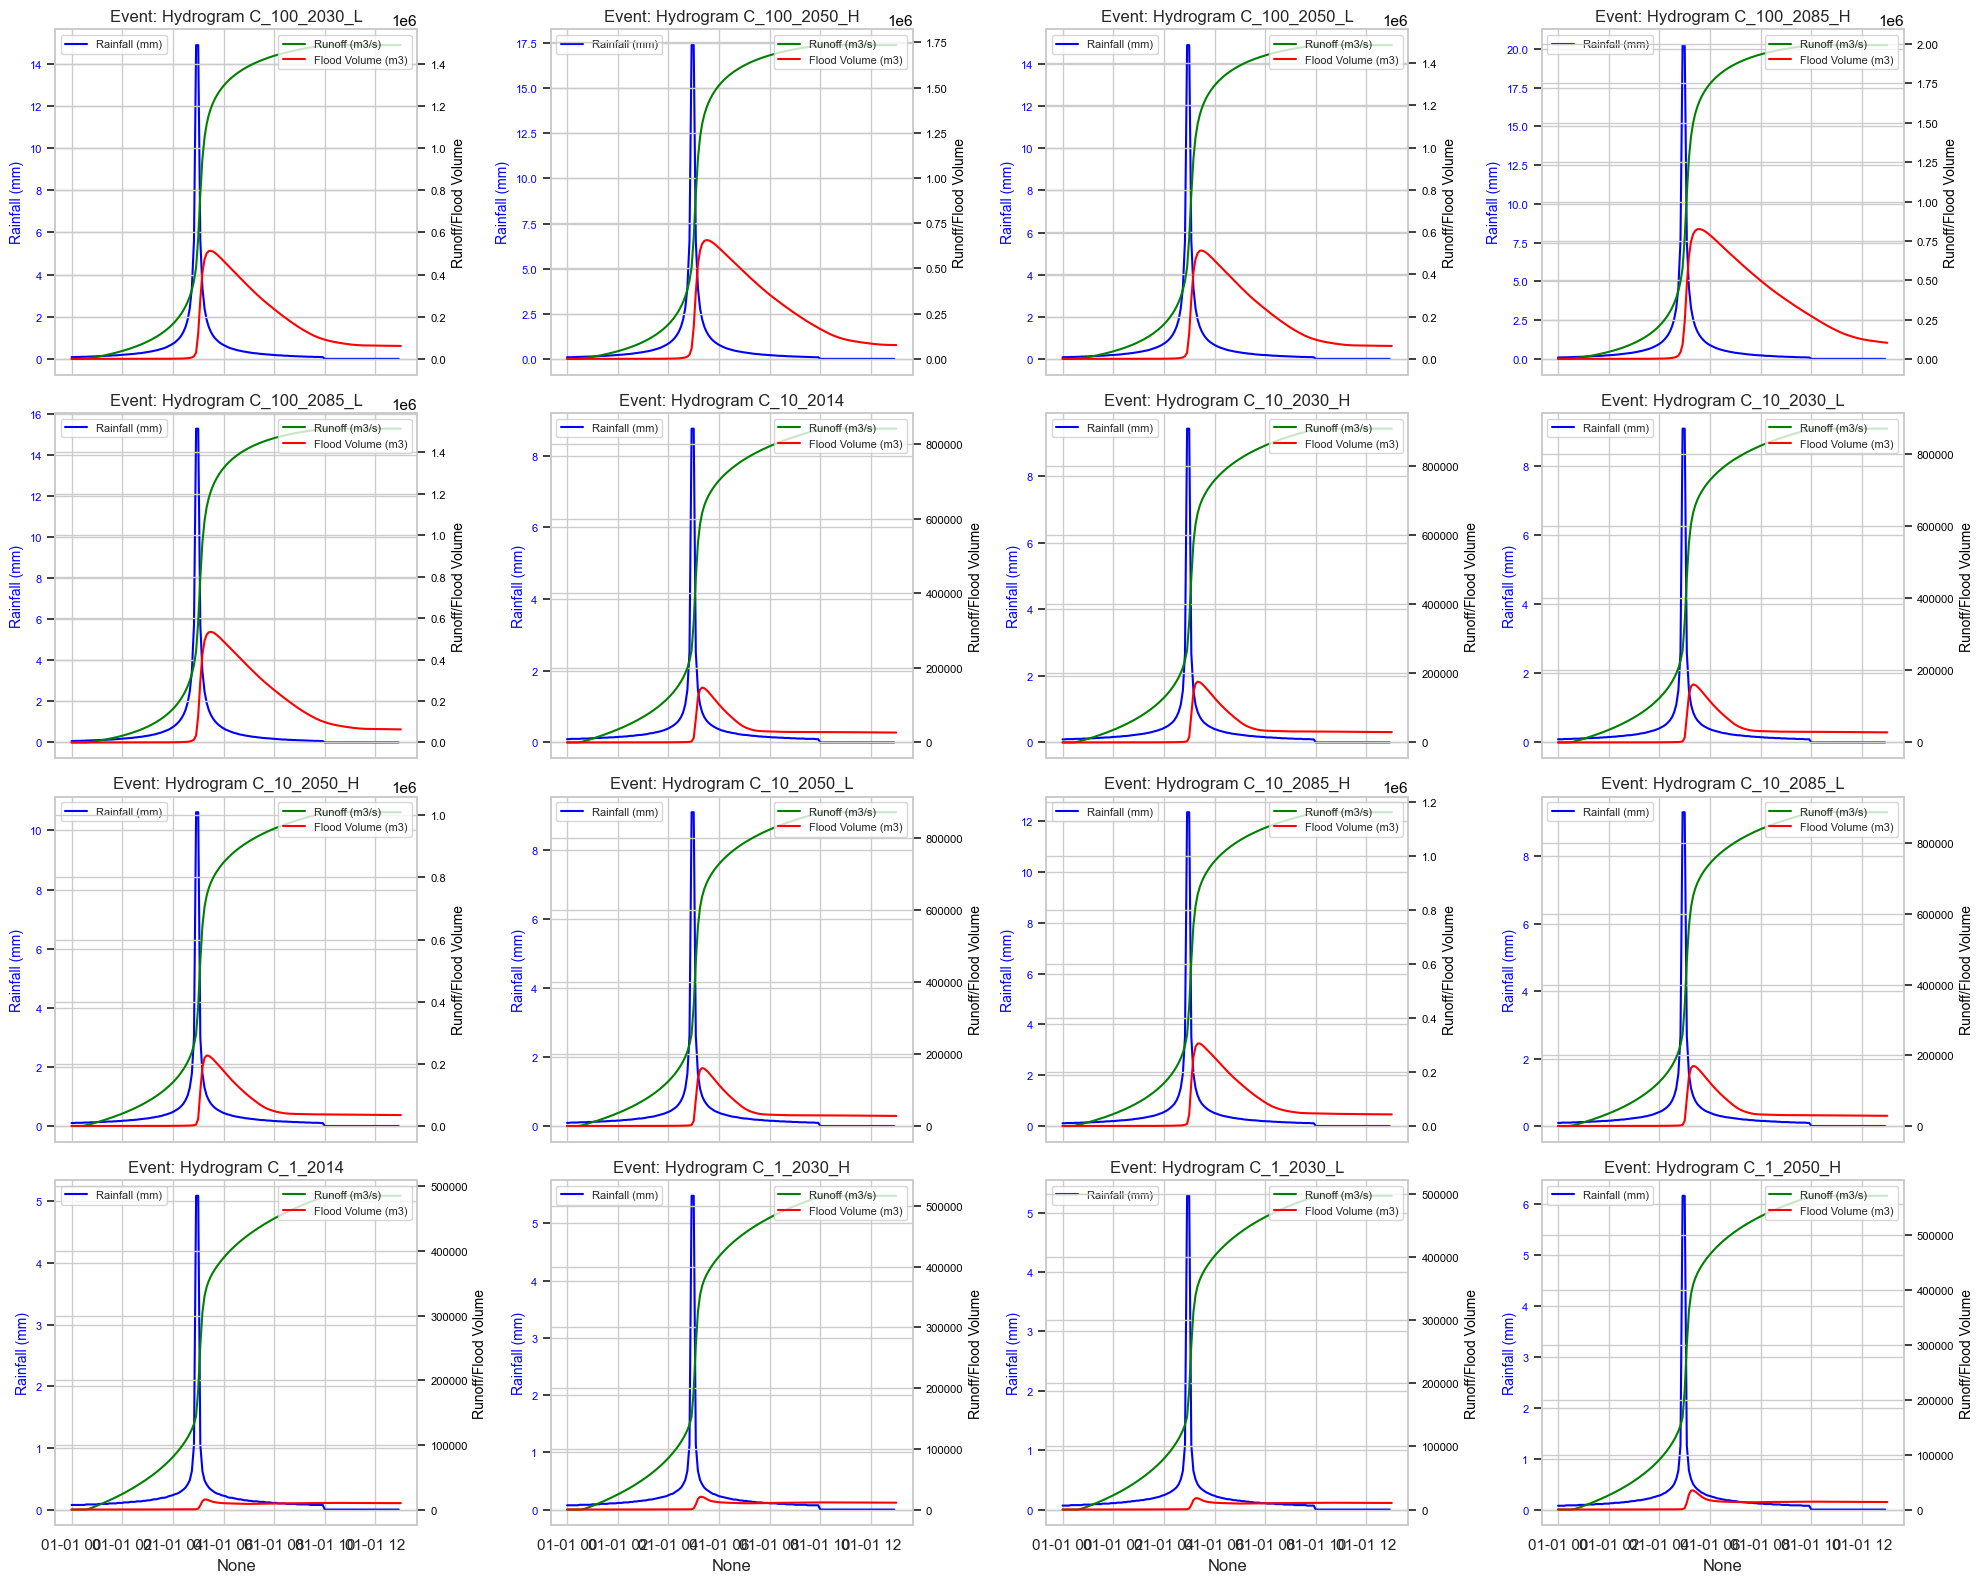

<Figure size 640x480 with 0 Axes>

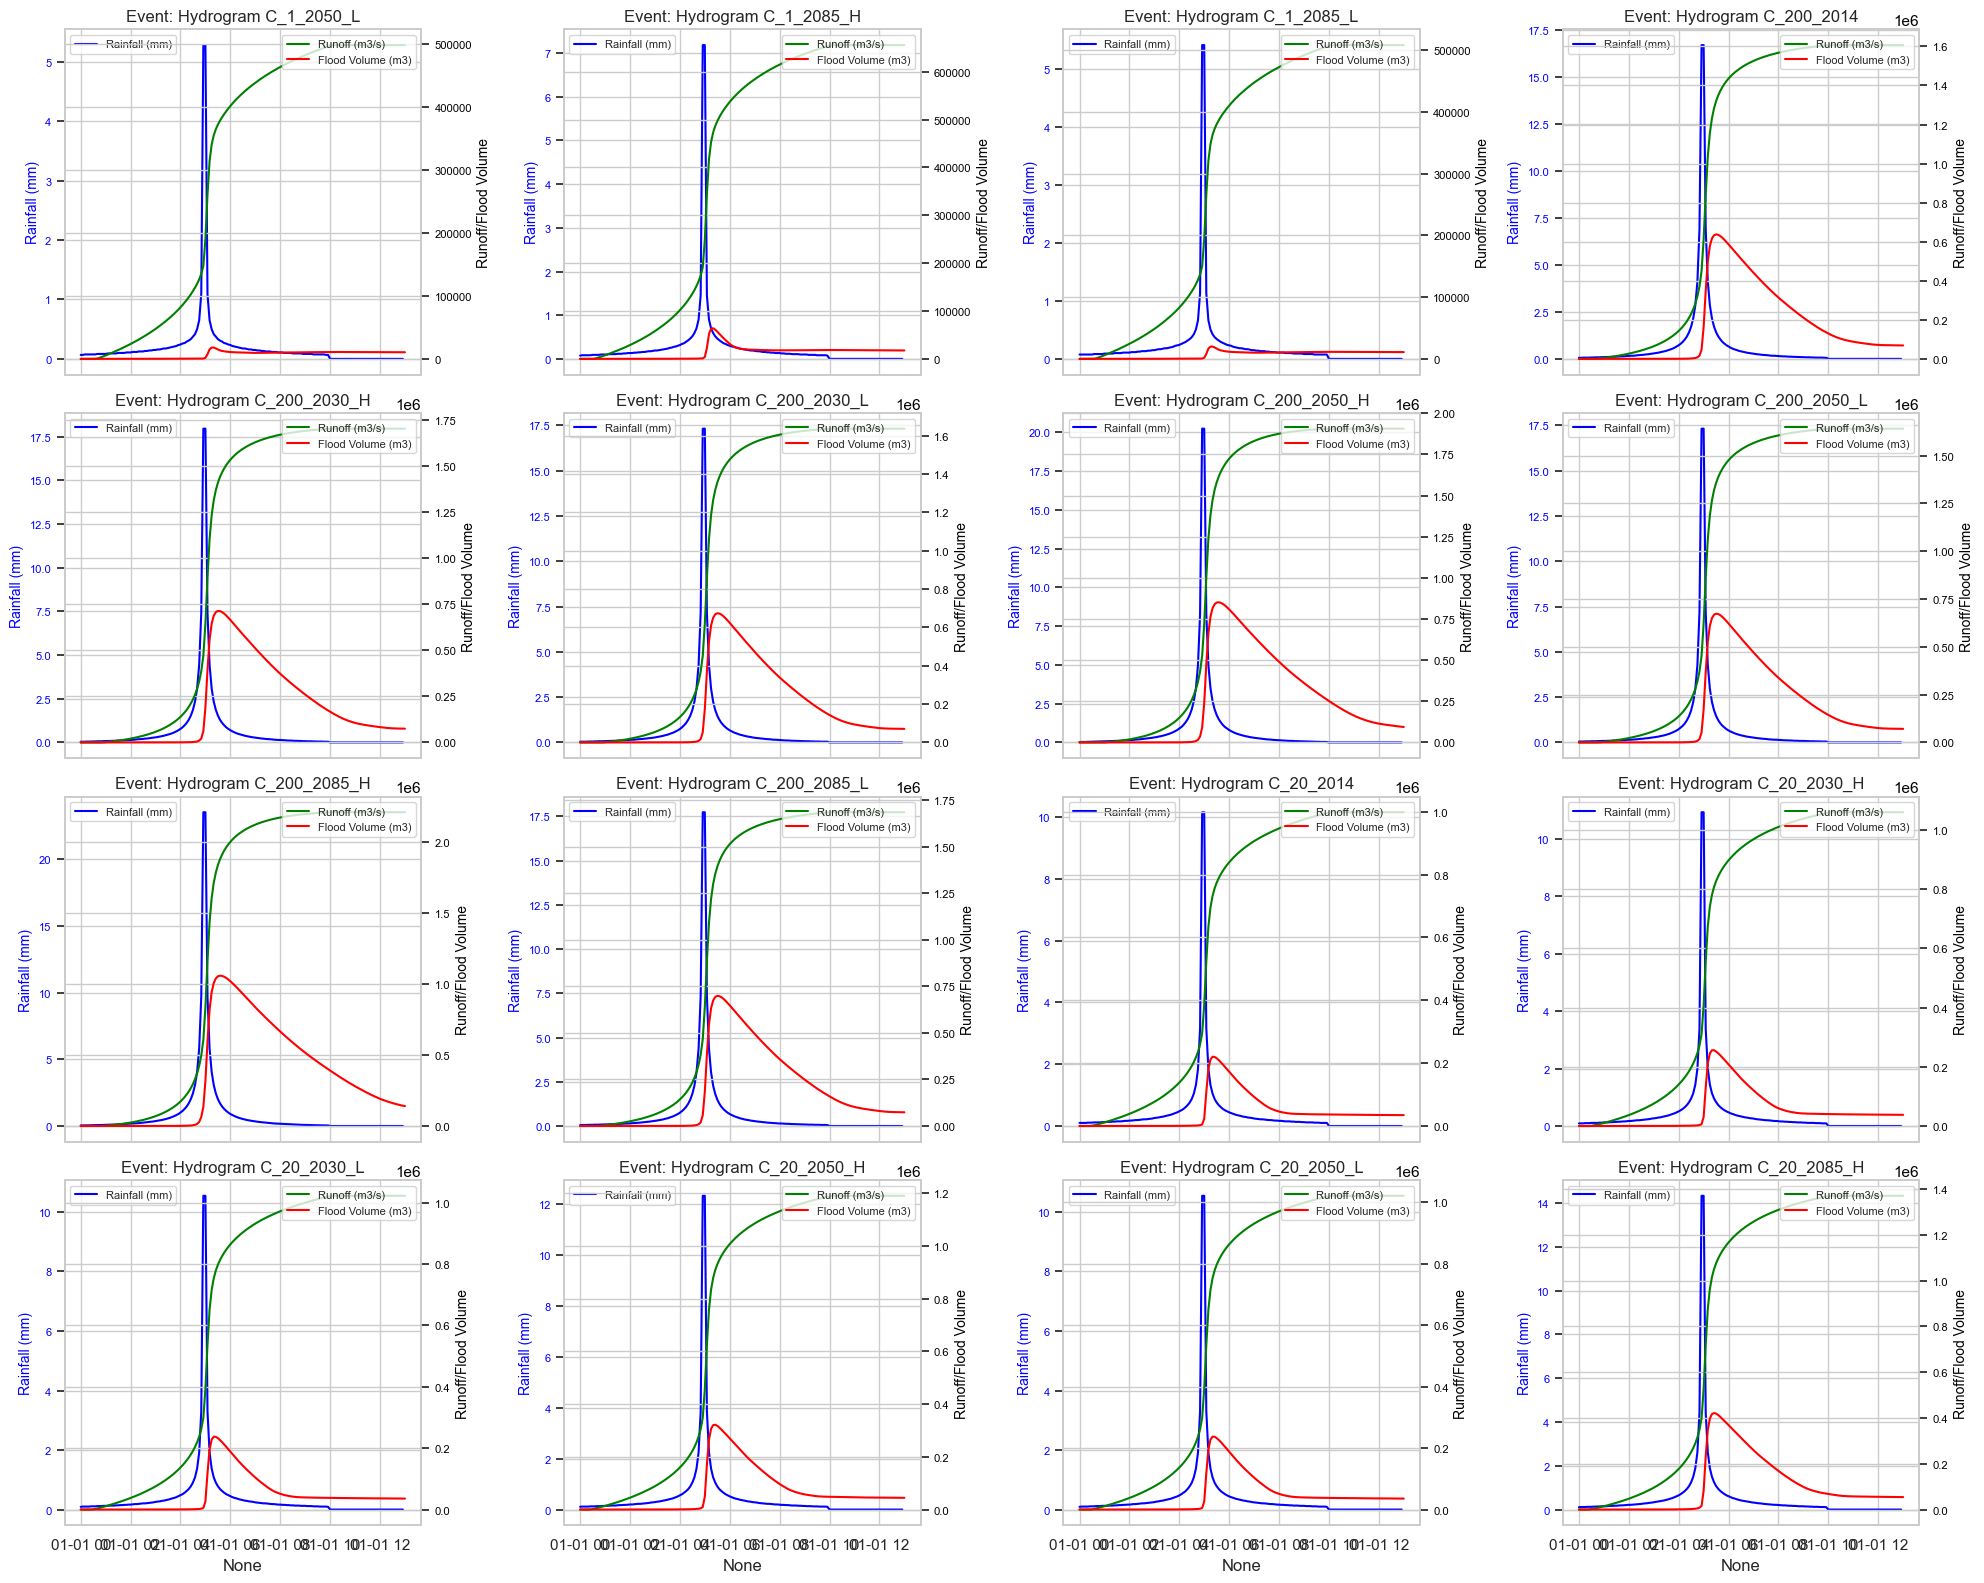

<Figure size 640x480 with 0 Axes>

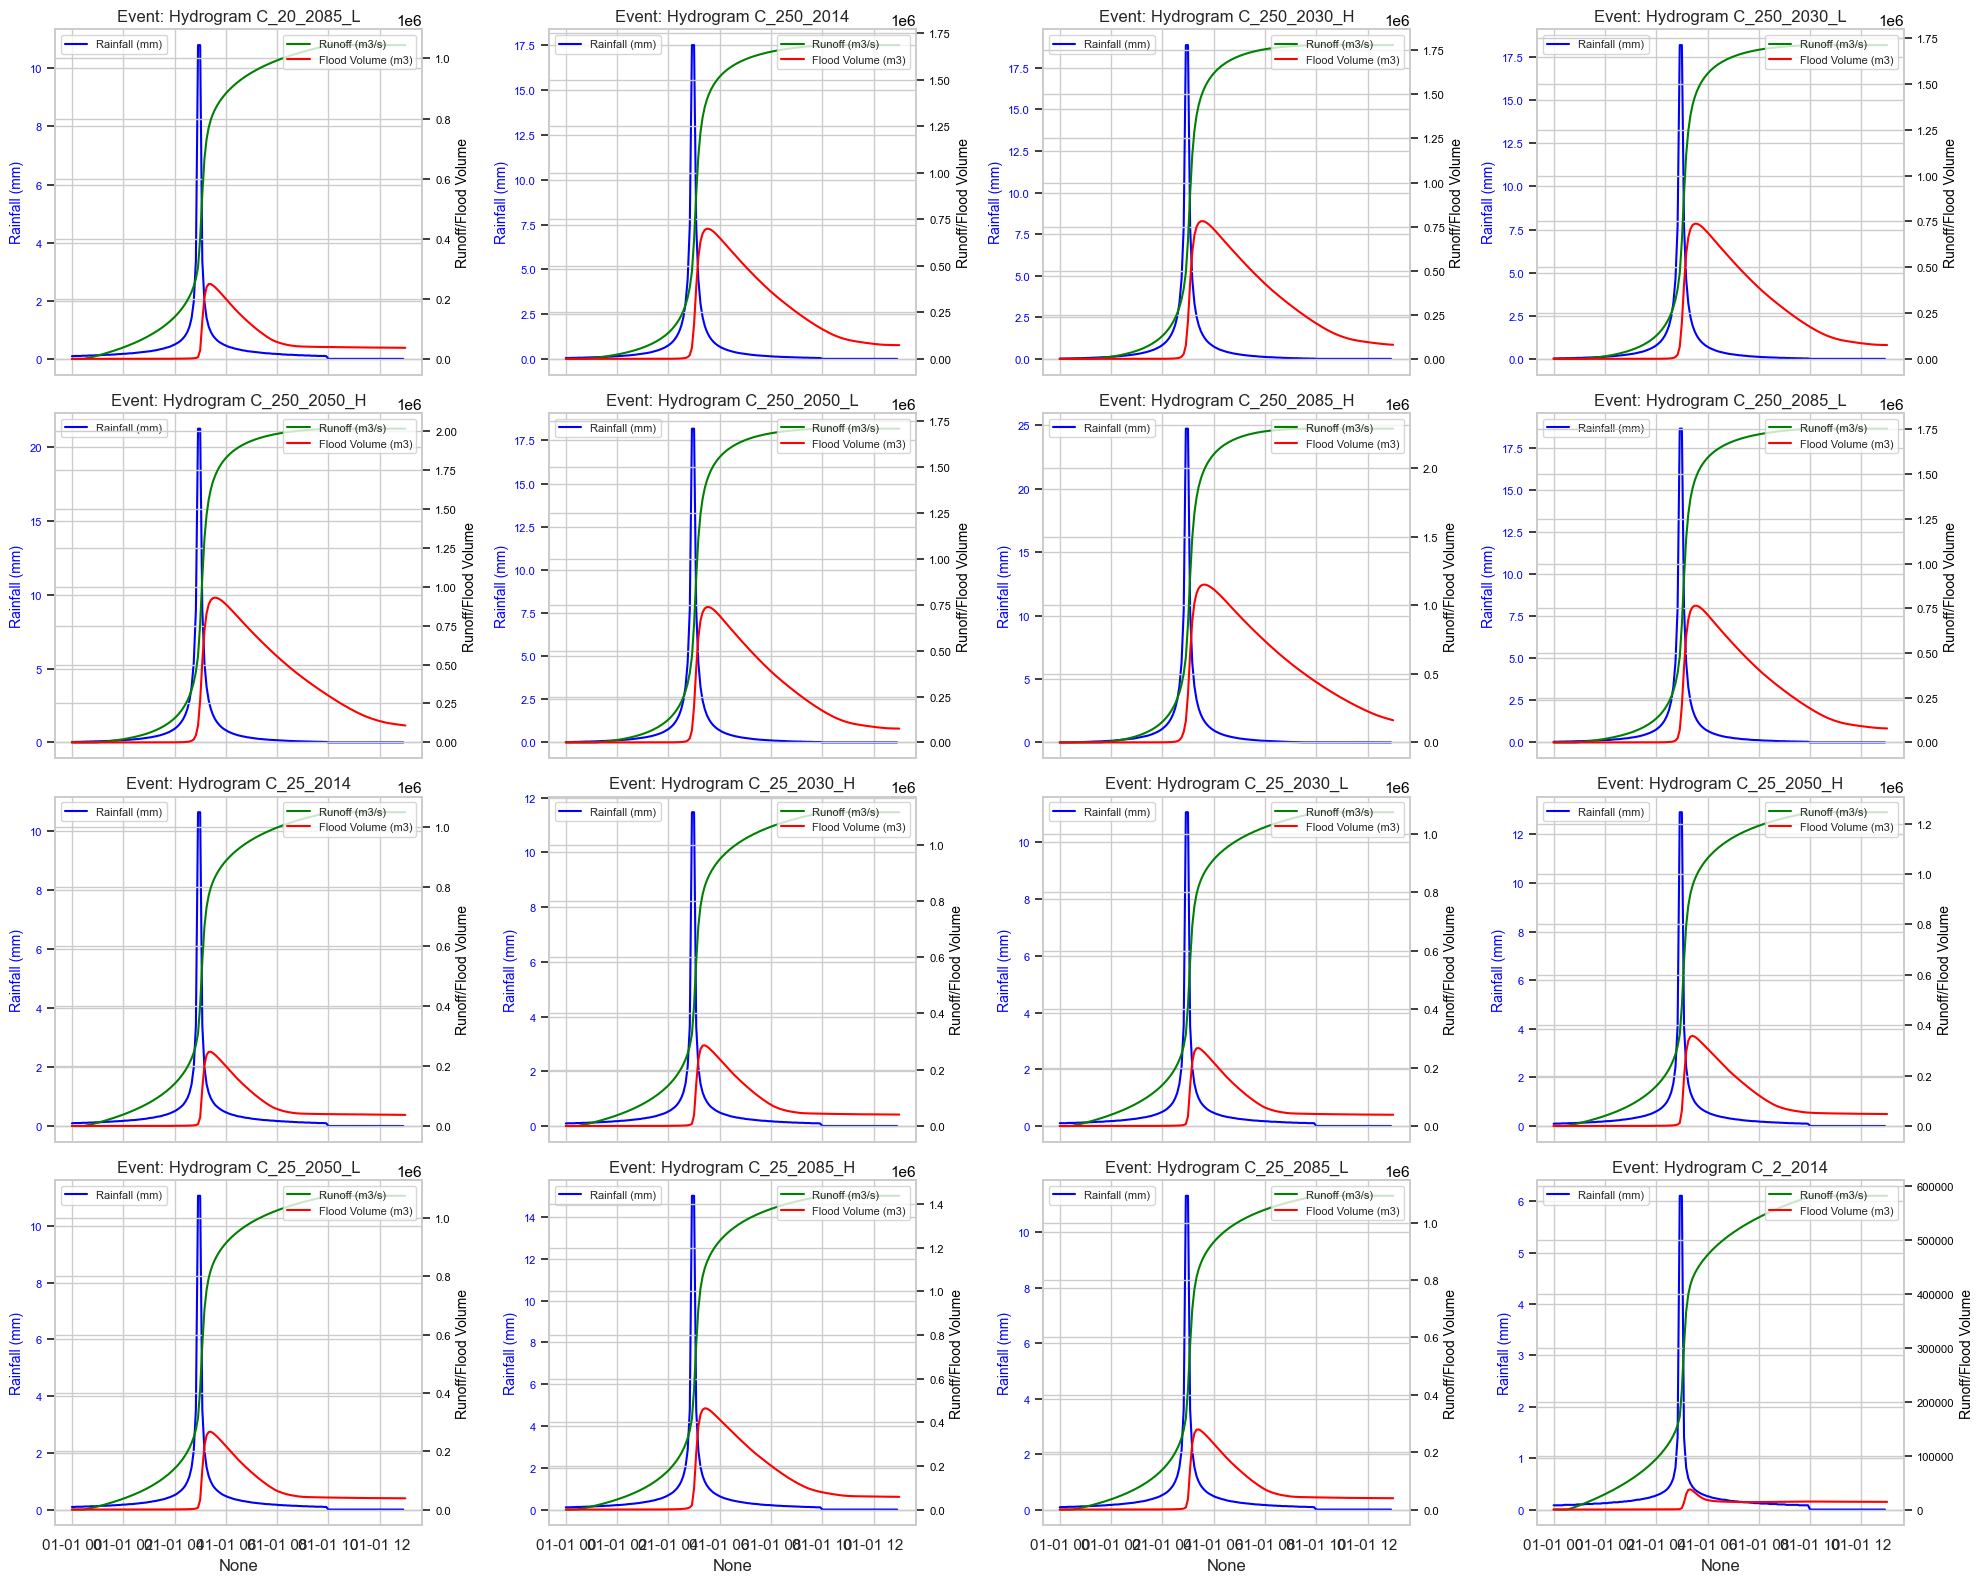

<Figure size 640x480 with 0 Axes>

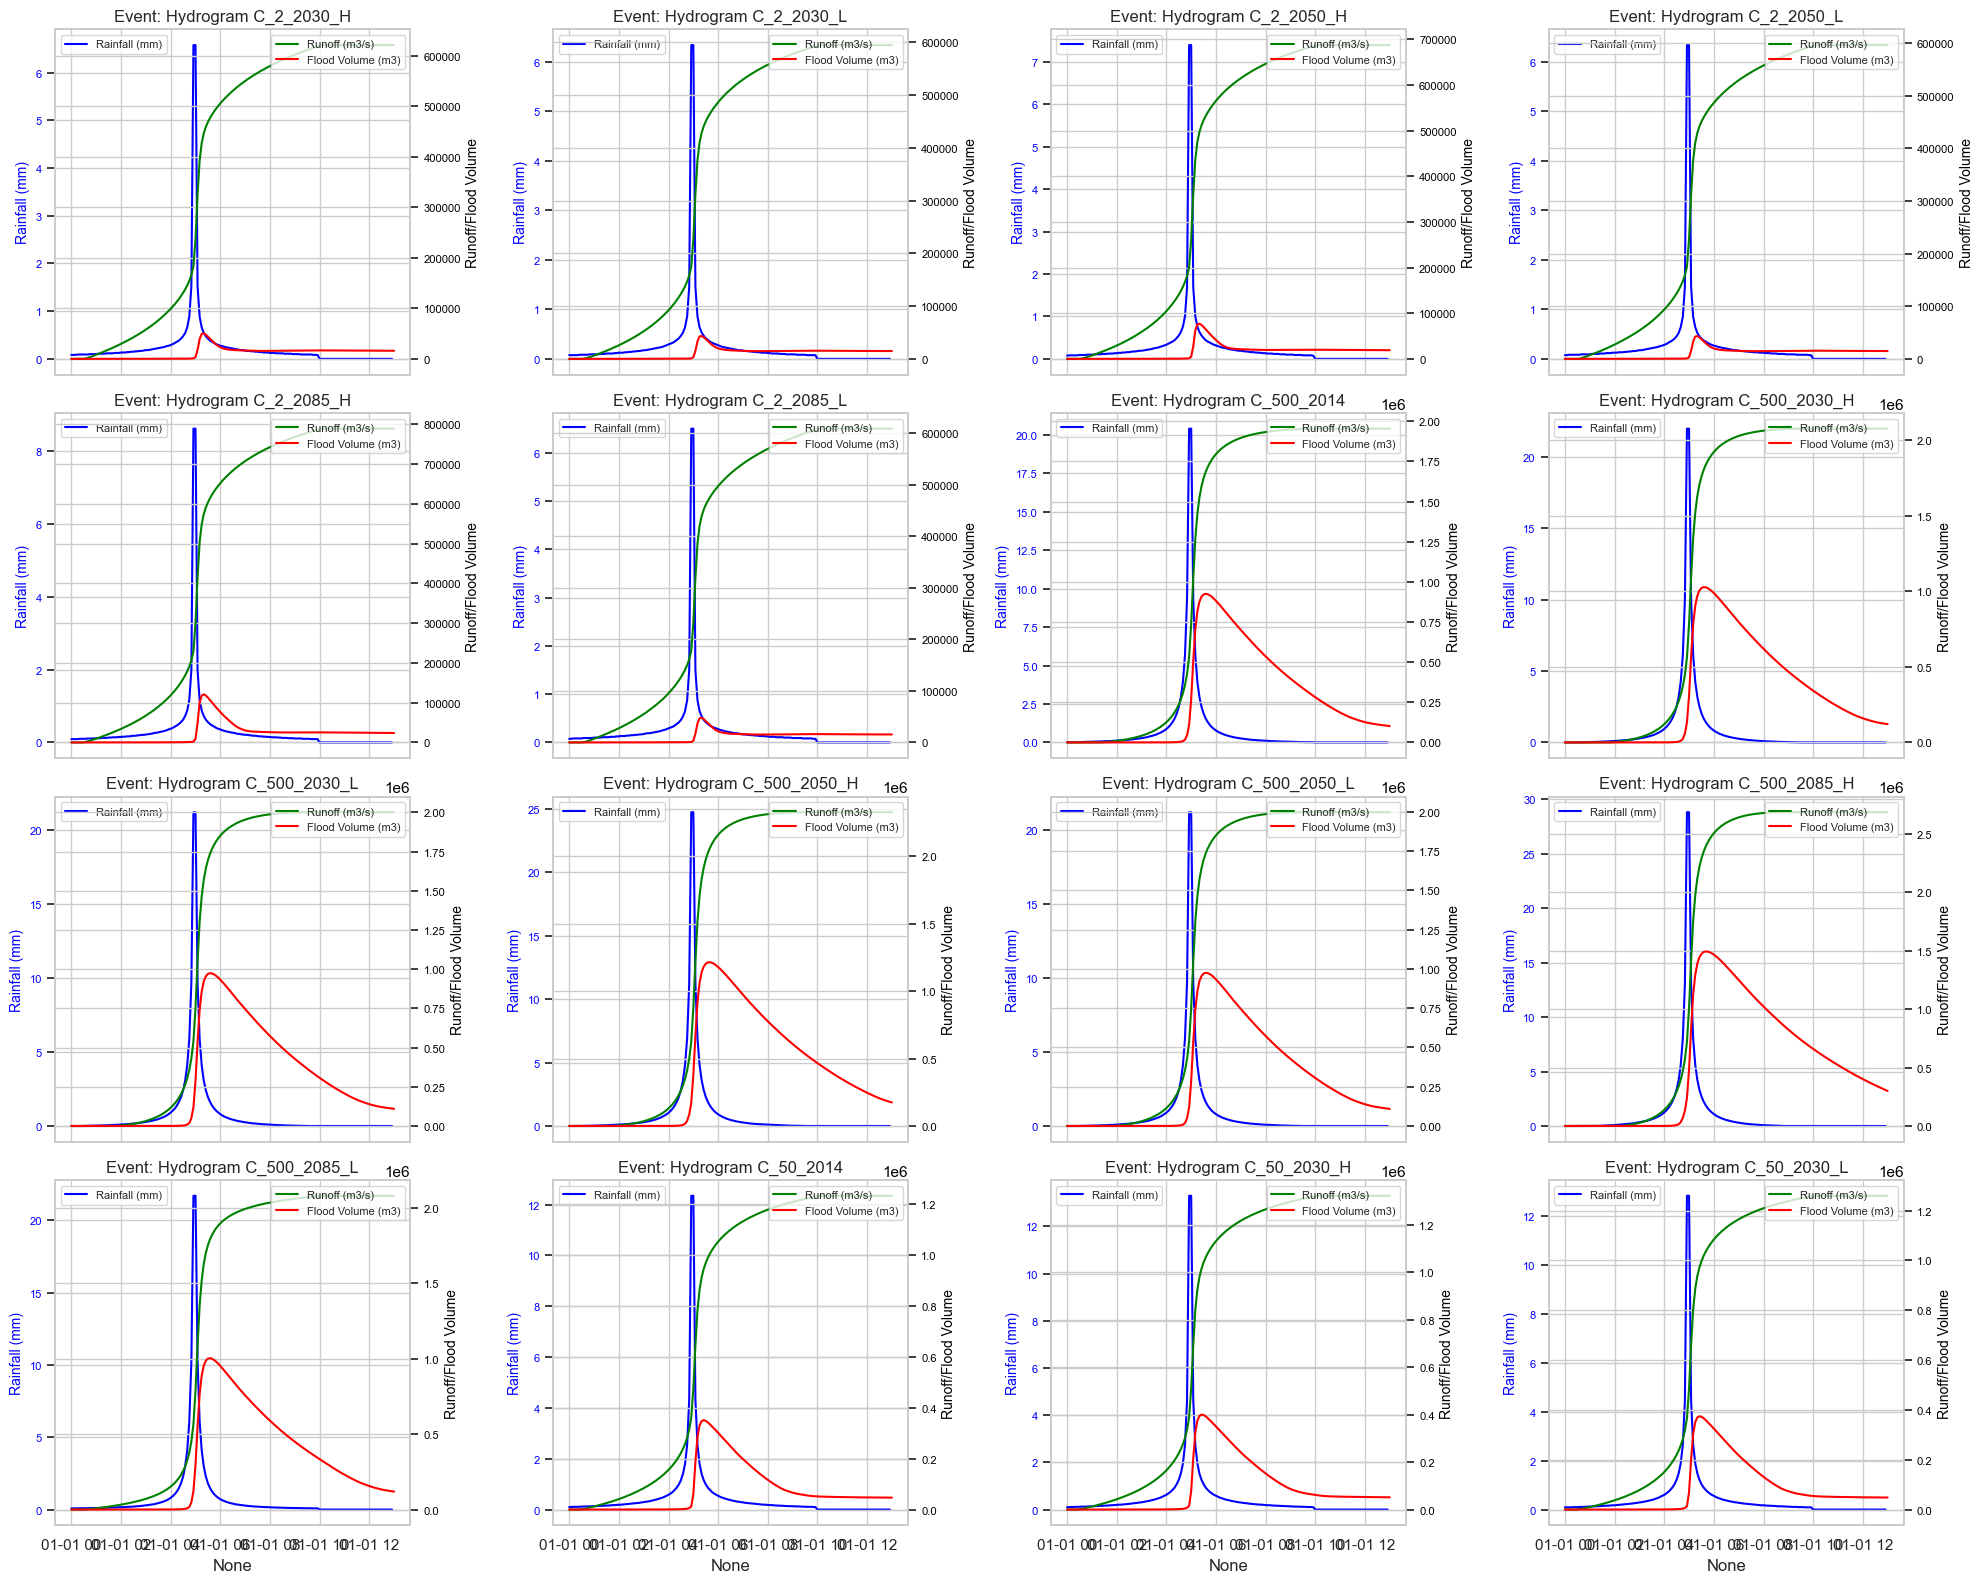

<Figure size 640x480 with 0 Axes>

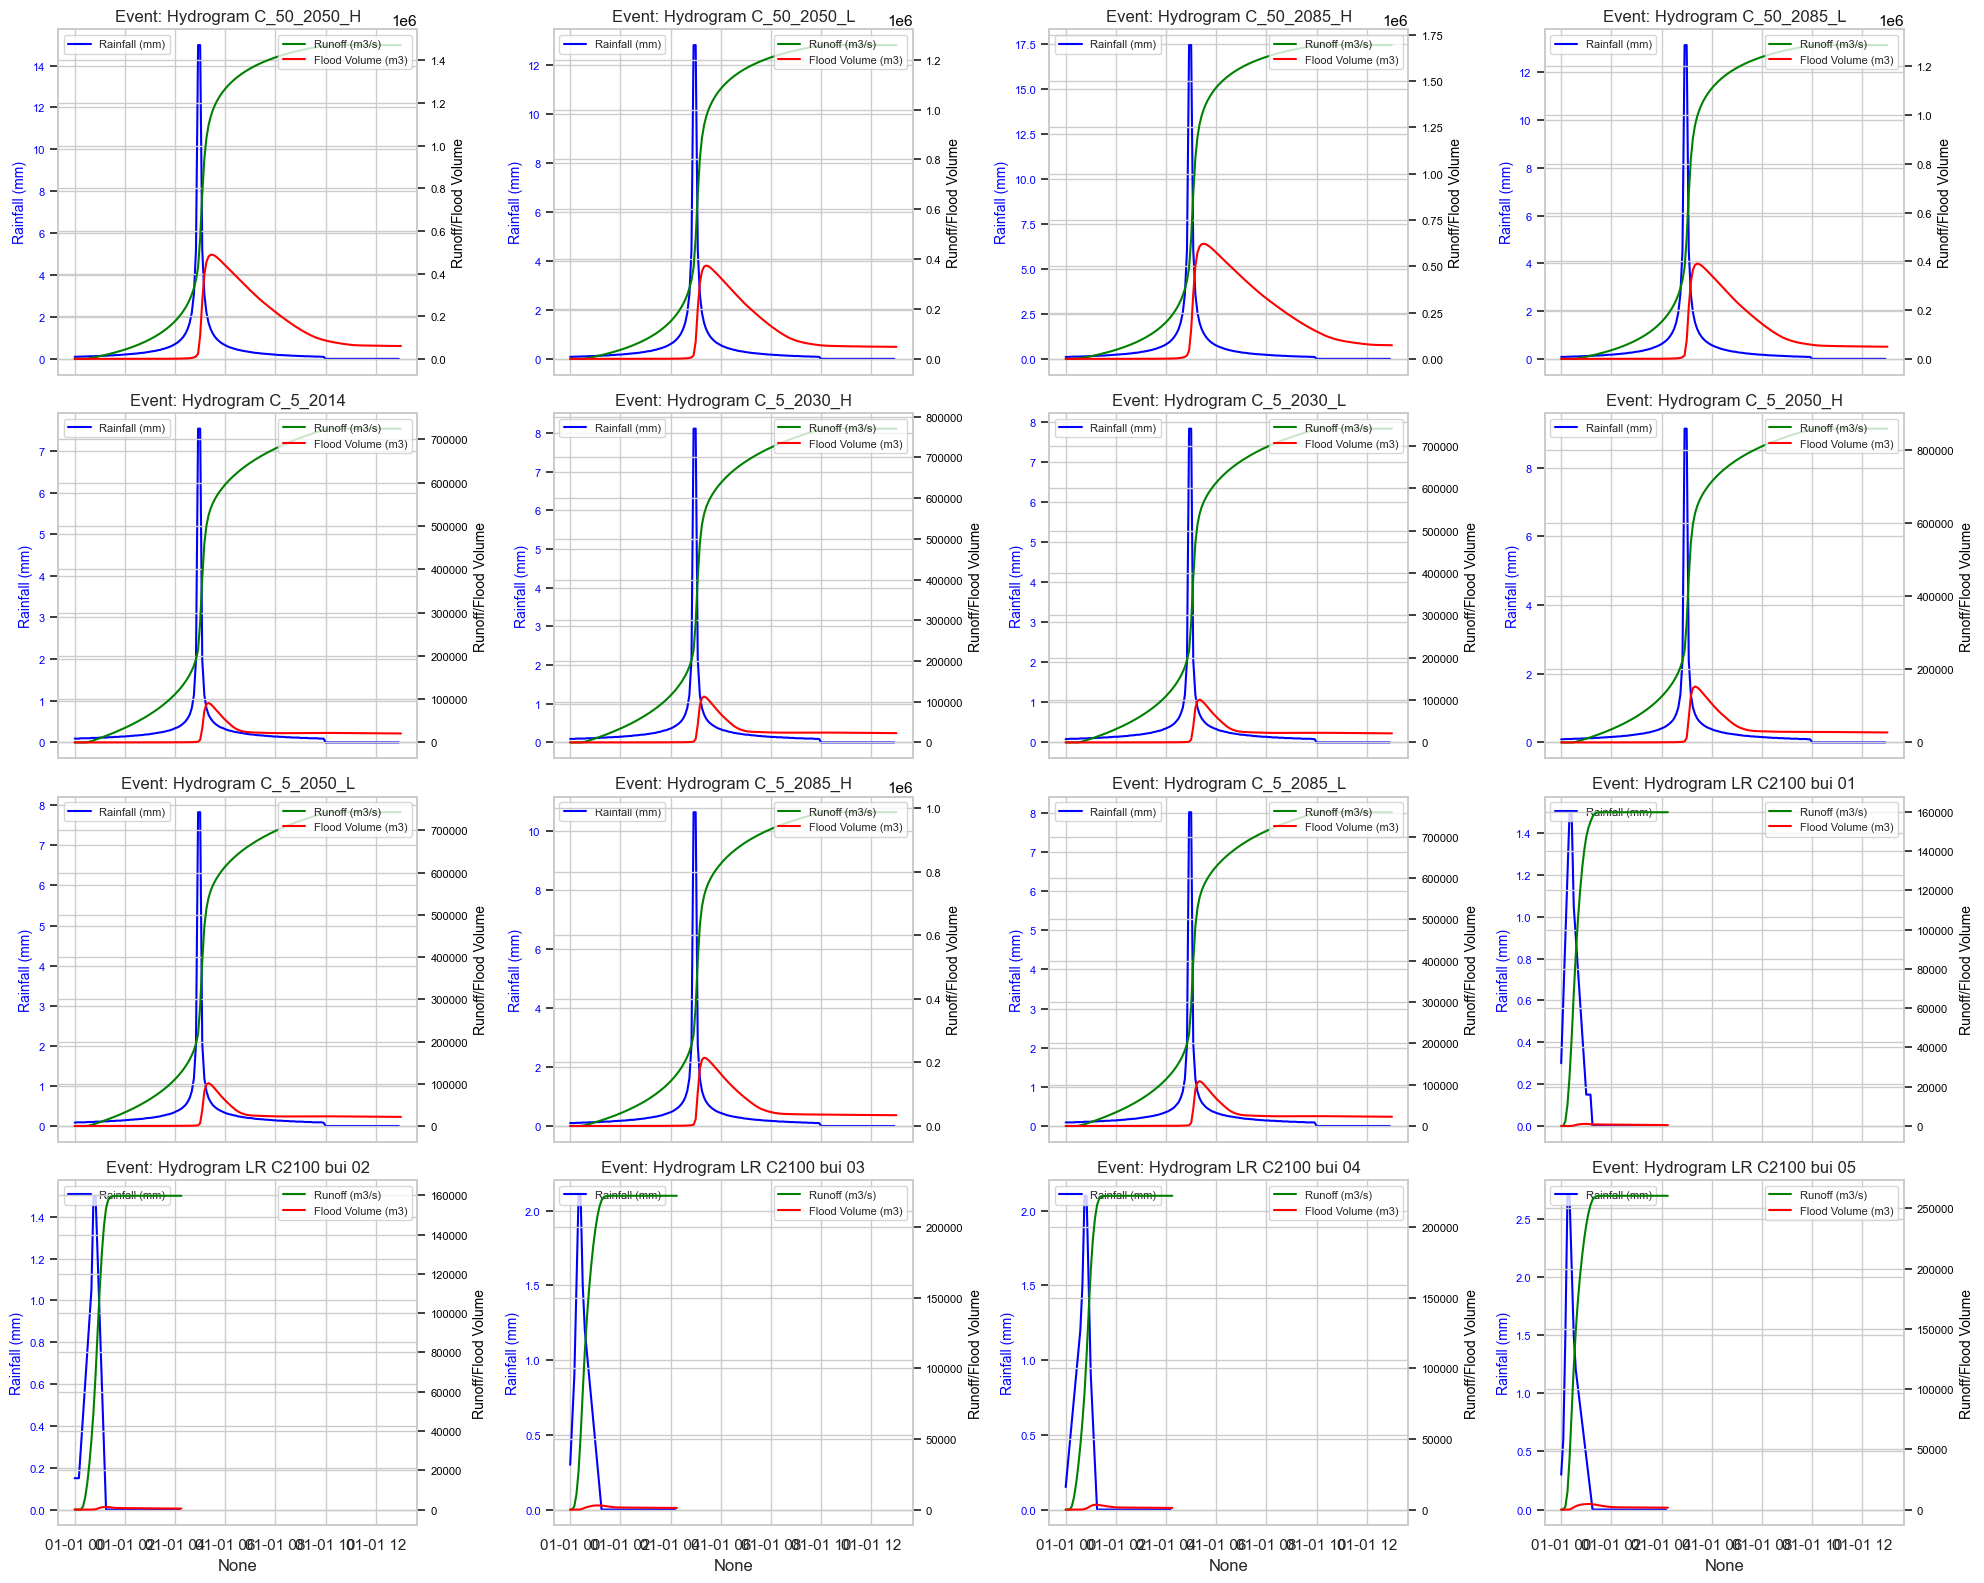

<Figure size 640x480 with 0 Axes>

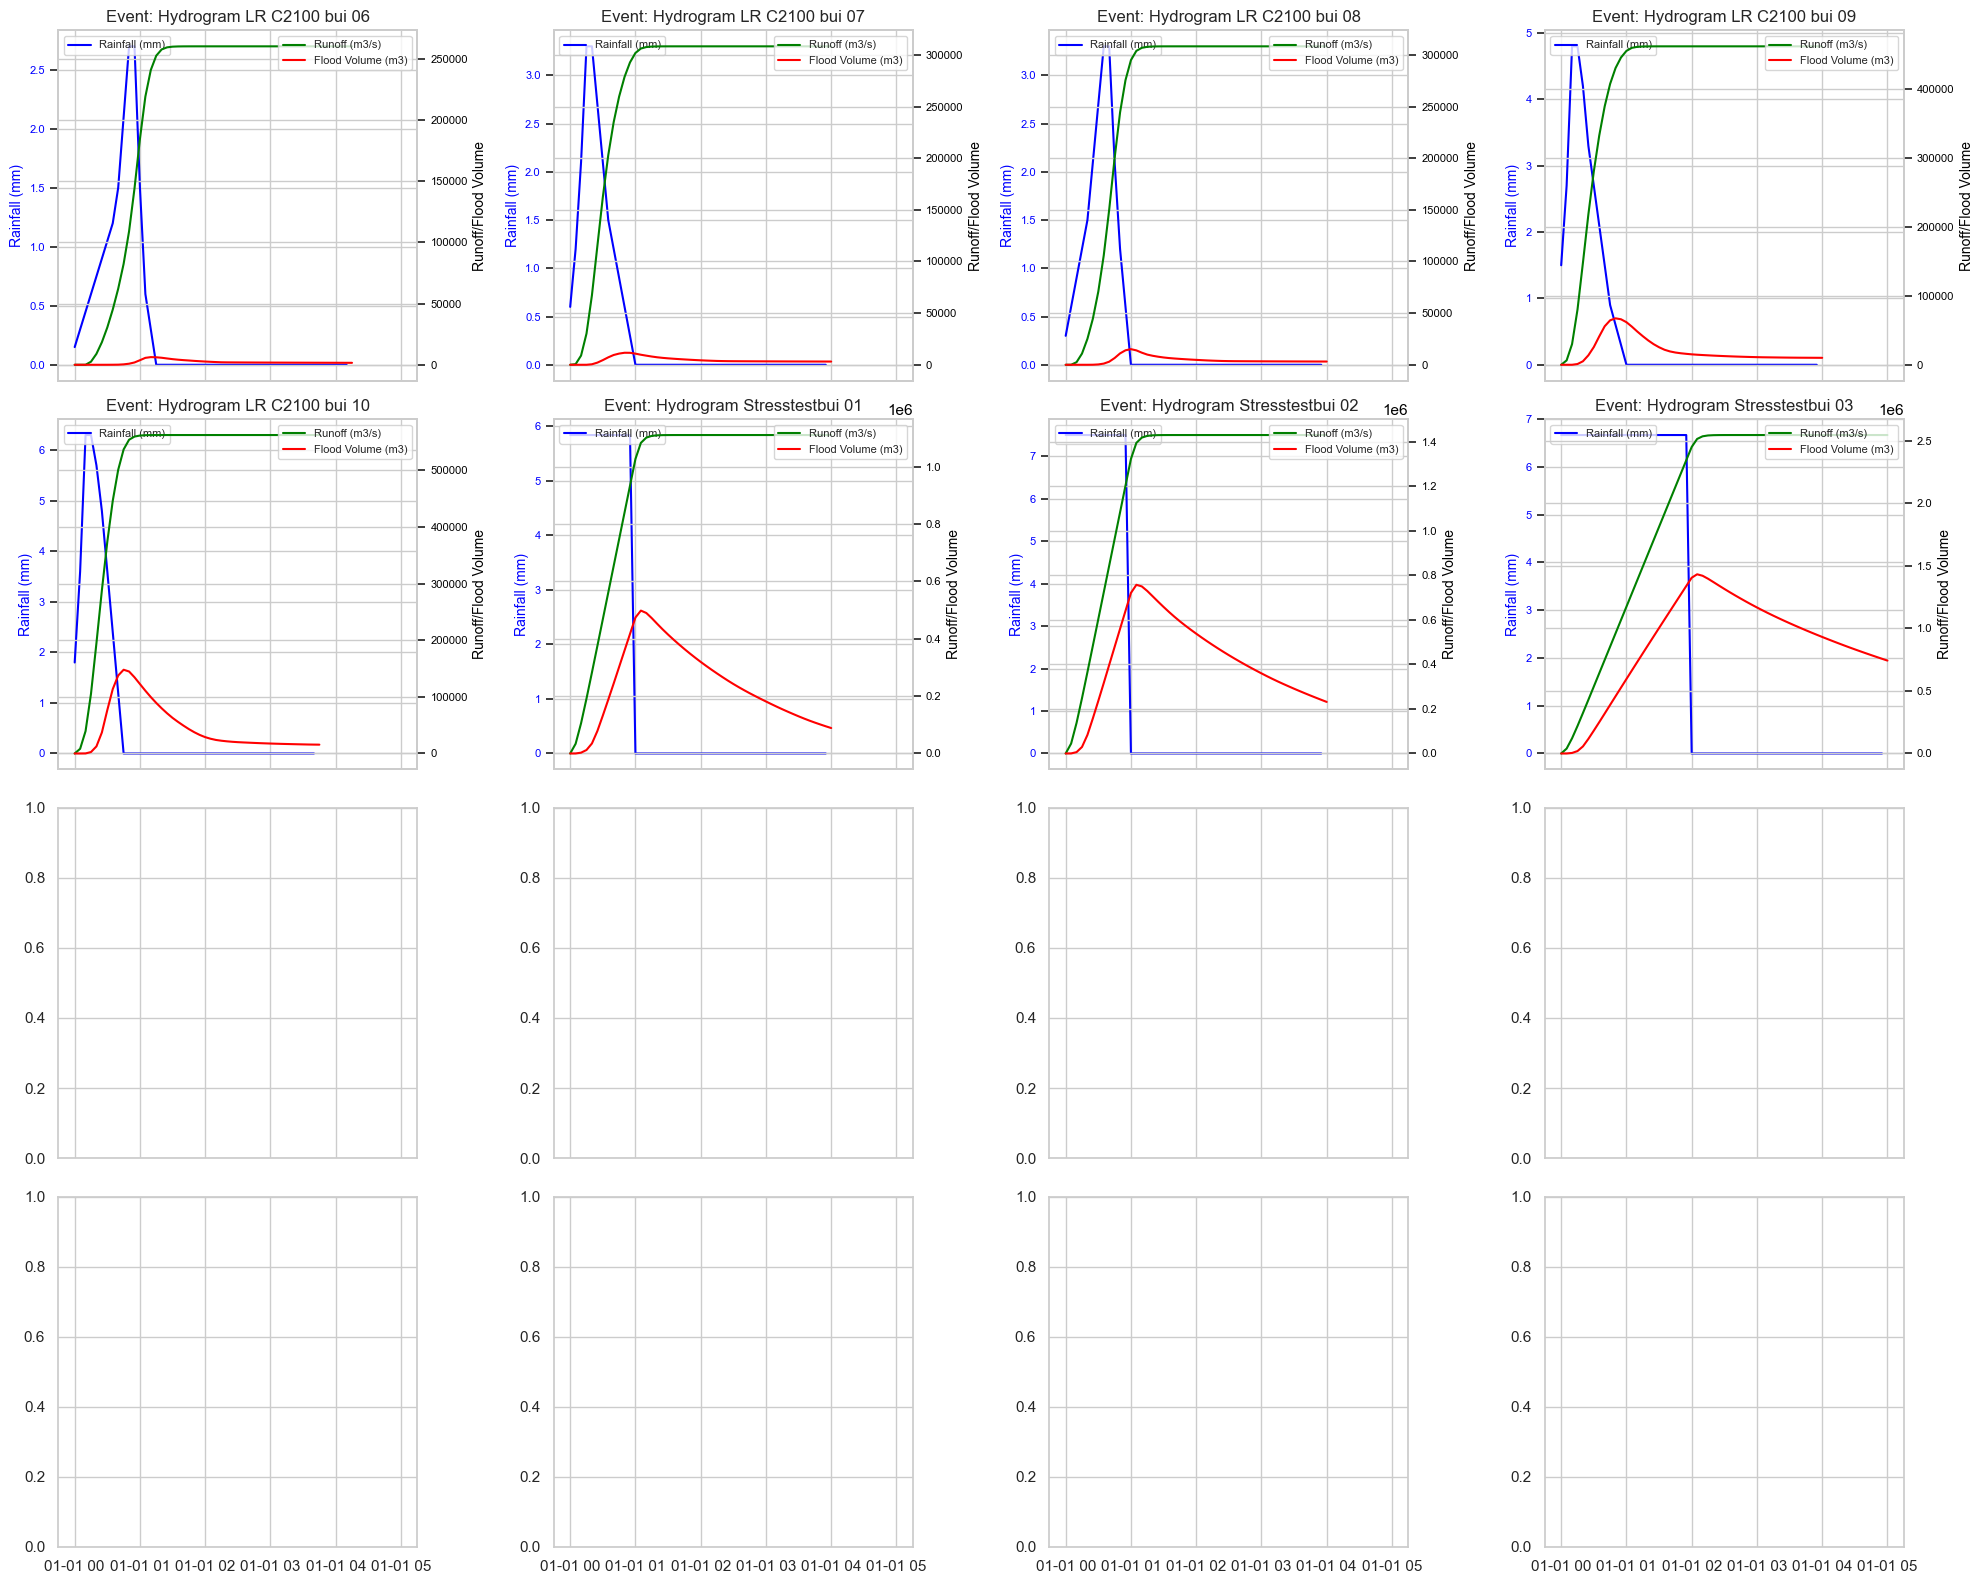

In [29]:
finished_events = [event for event in rainfall_events if dia_results[event]]

sns.set(style="whitegrid")

# Loop through finished events
for index, event_name in enumerate(finished_events):
    try:
        # Create a new figure for each 16 events
        if index % 16 == 0:
            if index > 0:
                plt.tight_layout()
                plt.show()
            fig, axes = plt.subplots(4, 4, figsize=(20, 16), sharex=True)
            axes = axes.flatten()

        # Process the event data
        event_data_df = process_event_data(event_name, bui_path, his_path, map_path)

        # Plot Rainfall on the left y-axis
        ax = axes[index % 16]
        sns.lineplot(
            x=event_data_df.index,
            y=event_data_df['Rainfall (mm)'],
            label='Rainfall (mm)',
            color='blue',
            ax=ax
        )
        ax.set_ylabel('Rainfall (mm)', color='blue', fontsize=10)
        ax.tick_params(axis='y', labelcolor='blue', labelsize=8)

        # Create a secondary y-axis for Runoff and Flood Volume
        ax2 = ax.twinx()
        sns.lineplot(
            x=event_data_df.index,
            y=event_data_df['Runoff (m3/s)'],
            label='Runoff (m3/s)',
            color='green',
            ax=ax2
        )
        sns.lineplot(
            x=event_data_df.index,
            y=event_data_df['Flood Volume (m3)'],
            label='Flood Volume (m3)',
            color='red',
            ax=ax2
        )
        ax2.set_ylabel('Runoff/Flood Volume', color='black', fontsize=10)
        ax2.tick_params(axis='y', labelcolor='black', labelsize=8)

        # Add title and legend
        ax.set_title(f"Event: {event_name}", fontsize=12)
        ax.legend(loc='upper left', fontsize=8)
        ax2.legend(loc='upper right', fontsize=8)

        # add show plots when the last of 16 is finished
        if index == len(finished_events) - 1 or (index + 1) % 16 == 0:
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error processing event {event_name}: {e}")

